<a href="https://colab.research.google.com/github/Adrianfc22/Final_Test_Vision/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [183]:
import os
import zipfile

In [184]:
data_dir = "/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset"
TEST = '/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/test'
TRAIN = '/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train'
VAL ='/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val'

In [185]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

import torch
import torch.nn as nn
import torchvision

# data loading and transforming
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets

# evaluation metrics visualisation
import seaborn as sns

# define a transform to read the data in as a tensor. A good practice when creating
# the data transforms is to use a flag to apply different preprocessing according
# to what is needed. You might also include other preprocessing functions.  
def transform_data(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize(300),
            transforms.CenterCrop(300),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

# check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")
print(device)

cuda:0


In [186]:
# add the transforms for training, validation and testing to a dict so they can be easily called
data_transforms = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform_data(x)) 
                  for x in [TRAIN, VAL, TEST]}

# prepare data loaders, set the batch_size
# consider changing the batch size because it can have effects in the accuracy of your architecture
dataloaders = {TRAIN: torch.utils.data.DataLoader(data_transforms[TRAIN], batch_size = 2, shuffle=True), 
               VAL: torch.utils.data.DataLoader(data_transforms[VAL], batch_size = 1, shuffle=True), 
               TEST: torch.utils.data.DataLoader(data_transforms[TEST], batch_size = 1, shuffle=True)}

# create a dict with the subsets' sizes
dataset_sizes = {x: len(data_transforms[x]) for x in [TRAIN, VAL]}

print("Dataset sizes: ", dataset_sizes)
classes = data_transforms[TRAIN].classes
print("Dataset classes in TRAIN: ", classes)
classes = data_transforms[VAL].classes
print("Dataset classes in VAL: ", classes)

Dataset sizes:  {'/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train': 253, '/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val': 253}
Dataset classes in TRAIN:  ['no', 'yes']
Dataset classes in VAL:  ['no', 'yes']


### Visualize an entire batch 

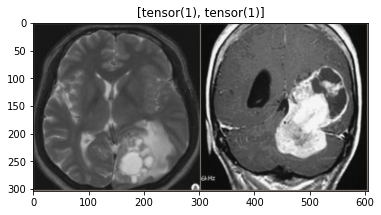

In [187]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

# obtain one batch of training images
inputs, classes = next(iter(dataloaders[TRAIN]))
out = torchvision.utils.make_grid(inputs)
# plot the images in the batch, along with the corresponding labels
imshow(out, title=[classes[x] for x in classes])

In [188]:
# Load the pretrained model VGG-16
pretrained_model = models.vgg16(pretrained=True)
print(pretrained_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [189]:
# freeze all the layers to implement transfer learning
for param in pretrained_model.features.parameters():
    param.required_grad = False


num_features_last_layer = pretrained_model.classifier[6].in_features
print("Num. of input nodes for the last fully-connected layer: ",num_features_last_layer)
classifier = list(pretrained_model.classifier.children())[:-1] 
print("Original classifier architecture:",classifier)

# extend the final classifier of VGG-16 
classifier.extend([nn.Linear(num_features_last_layer, len(classes))])
pretrained_model.classifier = nn.Sequential(*classifier) 
print("New classifier architecture",classifier)

Num. of input nodes for the last fully-connected layer:  4096
Original classifier architecture: [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]
New classifier architecture [Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=2, bias=True)]


In [190]:
import torch.optim as optim

# transfer the pretrained_model to GPU
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [191]:
# decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [192]:
# define the number of epochs to train for
n_epochs = 100

# call train
pretrained_model = train_model(pretrained_model, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/100


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 0.7180 Acc: 0.4941
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 0.6995 Acc: 0.4901
Epoch: 2/100
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 0.7183 Acc: 0.4783
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 0.6995 Acc: 0.4901
Epoch: 3/100
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 0.7109 Acc: 0.5217
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 0.6995 Acc: 0.4901
Epoch: 4/100
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 0.7199 Acc: 0.5059
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 0.6995 Acc: 0.4901
Epoch: 5/100
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 0.7121 Acc: 0.5059
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Los

In [194]:
torch.save(pretrained_model, './my_model_45.pt') 

In [195]:
def output_label(label):
    output_mapping = {
                 0: "No",
                 1: "Yes",
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Yes, Yes, 

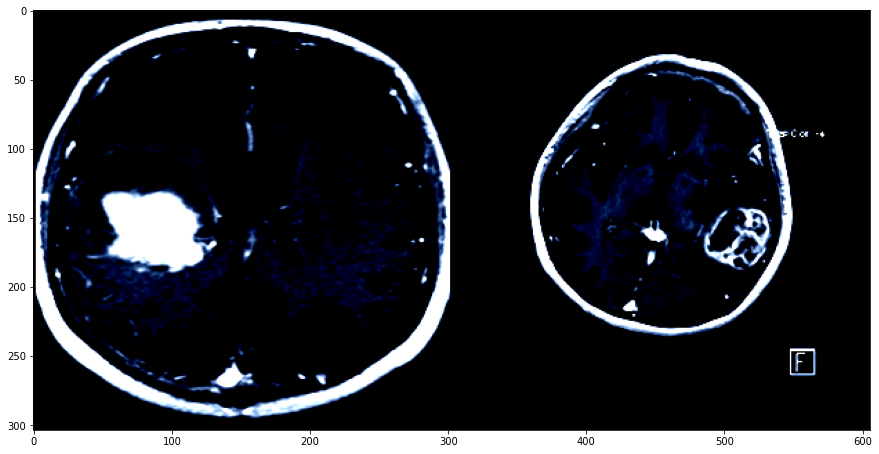

In [196]:
# obtain one batch of test images
images, labels= next(iter(dataloaders[TRAIN]))
grid = torchvision.utils.make_grid(images, nrow=20)
# get predictions

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ")

In [197]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [200]:
# transfer the pretrained_model to GPU
resnet18 = resnet18.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [201]:
# define the number of epochs to train for
n_epochs = 30

# call train
pretrained_model = train_model(resnet18, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 8.2144 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 8.9006 Acc: 0.0040
Epoch: 2/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 8.2160 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.1699 Acc: 0.0000
Epoch: 3/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 8.2381 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.2183 Acc: 0.0000
Epoch: 4/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 8.2119 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 8.9490 Acc: 0.0000
Epoch: 5/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 8.2144 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset

In [202]:
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [204]:
# transfer the pretrained_model to GPU
alexnet = alexnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [205]:
# define the number of epochs to train for
n_epochs = 30
# call train
pretrained_model = train_model(alexnet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 11.3696 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 10.6445 Acc: 0.0000
Epoch: 2/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 11.3431 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 10.6445 Acc: 0.0000
Epoch: 3/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 11.3402 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 10.6445 Acc: 0.0000
Epoch: 4/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 11.2979 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 10.6445 Acc: 0.0000
Epoch: 5/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 11.3545 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumo

In [206]:
squeezenet = models.squeezenet1_0(pretrained=True)
print(squeezenet)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [208]:
# transfer the pretrained_model to GPU
squeezenet = squeezenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [210]:
# define the number of epochs to train for
n_epochs = 30
# call train
pretrained_model = train_model(squeezenet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 14.0493 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 14.6092 Acc: 0.0000
Epoch: 2/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 14.0275 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 14.6092 Acc: 0.0000
Epoch: 3/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 13.9790 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 14.6092 Acc: 0.0000
Epoch: 4/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 13.9672 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 14.6092 Acc: 0.0000
Epoch: 5/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 14.0244 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumo

In [211]:
densenet = models.densenet161(pretrained=True)
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [214]:
# transfer the pretrained_model to GPU
densenet = densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [215]:
# define the number of epochs to train for
n_epochs = 30
# call train
pretrained_model = train_model(densenet, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 7.8465 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.8343 Acc: 0.0000
Epoch: 2/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 7.8457 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.2696 Acc: 0.0000
Epoch: 3/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 7.8574 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.1834 Acc: 0.0000
Epoch: 4/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 7.8579 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/val Loss: 9.3908 Acc: 0.0000
Epoch: 5/30
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset/train Loss: 7.8369 Acc: 0.0000
/content/drive/MyDrive/Colab_Notebooks/archive/brain_tumor_dataset

In [ ]:
inception = models.inception_v3(pretrained=True)
inception.aux_logits=False
inception.fc = nn.Linear(2048, 2)
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# transfer the pretrained_model to GPU
inception = inception.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [ ]:
# define the number of epochs to train for
n_epochs = 10
# call train
pretrained_model = train_model(inception, criterion, optimizer, exp_lr_scheduler, num_epochs=n_epochs)

Epoch: 1/10


ValueError: ignored